In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr
import osmnx
osmnx.settings.default_crs = "EPSG:4326"
# script file, not a module 
import utils

## Importing audio data

In [2]:
gdf = gpd.read_file('..\\output\\distributed_data.GEOJSON', engine='pyogrio', use_arrow=True)
# gdf = gpd.read_file('..\\output\\road_dba_gdf.GEOJSON', engine='pyogrio', use_arrow=True)

In [10]:
#EPSG4326 bounding boxes for science park, oud zuilen, and lunetten
bbox_sp = (52.079691,52.091478,5.160871,5.188251)
bbox_oz = (52.122212,52.132171,5.078688,5.096025)
bbox_lu = (52.057135,52.068401,5.125294,5.143876)

## Combining with OSM street data

In [6]:
g = osmnx.graph_from_place('Utrecht, the Netherlands')
# g = osmnx.graph_from_place('Utrecht, the Netherlands', custom_filter={'highway':True, 'bridge':True, 'landuse':True, 'railway':True})

In [ ]:
# * osm params
car_road_types = ['highway', 'trunk', 'primary', 'secondary', 'tertiary', 'unclassified', 'residential', 'living_street', 'busway', 'service']
# notes: style guide only indicates unclassified for motor vehicle roads; living_street = erf (<15kmph), highway/trunk = snelweg/autoweg


In [ ]:
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
gdf

,y,x,dBA_rivm,median_speed,median_dBA_raw,median_dBA_reg_adj,geometry
0,461585.0,129735.0,50,NaN,NaN,NaN,POINT (129735.000 461585.000)
1,461585.0,129745.0,50,NaN,NaN,NaN,POINT (129745.000 461585.000)
2,461585.0,129755.0,51,NaN,NaN,NaN,POINT (129755.000 461585.000)
3,461585.0,129765.0,51,NaN,NaN,NaN,POINT (129765.000 461585.000)
4,461585.0,129775.0,51,NaN,NaN,NaN,POINT (129775.000 461585.000)
...,...,...,...,...,...,...,...
1502727,450115.0,142775.0,59,NaN,NaN,NaN,POINT (142775.000 450115.000)
1502728,450115.0,142785.0,62,NaN,NaN,NaN,POINT (142785.000 450115.000)
1502729,450115.0,142795.0,66,NaN,NaN,NaN,POINT (142795.000 450115.000)
1502730,450115.0,142805.0,66,NaN,NaN,NaN,POINT (142805.000 450115.000)


In [ ]:
# * Isolating area: lunetten
lunetten = osmnx.truncate.truncate_graph_bbox(g, bbox=(52.057135,52.068401,5.125294,5.143876))
node_gdf, edge_gdf = osmnx.graph_to_gdfs(lunetten)
road_gdf = edge_gdf[edge_gdf['maxspeed'].notna() & edge_gdf['highway'].isin(car_road_types)]

for col in road_gdf.columns:
    road_gdf[col] = road_gdf[col].apply(lambda x: x[0] if type(x) == list else x)
    

# Creating dBA_road gdf
road_gdf = road_gdf.to_crs(gdf.crs)
road_dba_gdf = gdf.sjoin_nearest(road_gdf, max_distance=10)

road_dba_gdf = road_dba_gdf[['x', 'y', 'dBA_rivm', 'median_dBA_raw', 'median_dBA_reg_adj', 'geometry', 'maxspeed', 'highway', 'bridge', 'junction', ]]
road_dba_gdf = road_dba_gdf.rename(columns={'median_dBA_raw': 'dBA_raw', 'median_dBA_reg_adj': 'dBA_reg'})

road_dba_gdf['maxspeed'] = pd.to_numeric(road_dba_gdf['maxspeed'])
road_dba_gdf['junction'] = road_dba_gdf['junction'].apply(lambda x: isinstance(x, str)) # otherwise None
road_dba_gdf['bridge'] = road_dba_gdf['bridge'].apply(lambda x: isinstance(x, str)) # otherwise None

for rt in car_road_types:
    column_name = f"rt_{rt}"
    road_dba_gdf[column_name] = road_dba_gdf['highway'] == rt

road_dba_gdf = road_dba_gdf.drop_duplicates()


road_dba_gdf


,x,y,dBA_rivm,dBA_raw,dBA_reg,geometry,maxspeed,highway,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service
1075419,137035.0,453375.0,54,NaN,NaN,POINT (137035.000 453375.000),30,residential,False,False,False,False,False,False,False,False,True,False,False,False
1075420,137045.0,453375.0,54,NaN,NaN,POINT (137045.000 453375.000),30,residential,False,False,False,False,False,False,False,False,True,False,False,False
1075421,137055.0,453375.0,54,NaN,NaN,POINT (137055.000 453375.000),30,residential,False,False,False,False,False,False,False,False,True,False,False,False
1075422,137065.0,453375.0,54,NaN,NaN,POINT (137065.000 453375.000),30,residential,False,False,False,False,False,False,False,False,True,False,False,False
1075453,137375.0,453375.0,65,NaN,NaN,POINT (137375.000 453375.000),30,residential,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237805,137735.0,452135.0,53,NaN,NaN,POINT (137735.000 452135.000),15,living_street,False,False,False,False,False,False,False,False,False,True,False,False
1237806,137745.0,452135.0,53,NaN,NaN,POINT (137745.000 452135.000),15,living_street,False,False,False,False,False,False,False,False,False,True,False,False
1237807,137755.0,452135.0,54,NaN,NaN,POINT (137755.000 452135.000),15,living_street,False,False,False,False,False,False,False,False,False,True,False,False
1237808,137765.0,452135.0,54,NaN,NaN,POINT (137765.000 452135.000),15,living_street,False,False,False,False,False,False,False,False,False,True,False,False


In [ ]:
road_dba_gdf.to_file('..\\output\\model_in1.GEOJSON')

In [ ]:
edge_gdf['highway'].value_counts()

highway
footway                                     2030
residential                                  748
cycleway                                     502
living_street                                400
path                                         354
service                                      303
tertiary                                     154
[steps, footway]                              84
[service, footway]                            68
pedestrian                                    58
[footway, living_street]                      38
busway                                        19
[path, living_street]                         16
[pedestrian, living_street]                    8
[cycleway, residential]                        8
secondary                                      8
[cycleway, living_street]                      8
[path, service]                                6
unclassified                                   6
[path, footway]                                4
[cycleway, s

In [ ]:
road_dba_gdf['rt_busway'].value_counts()

rt_busway
False    4066
True       64
Name: count, dtype: int64

In [ ]:
np.isnan(road_dba_gdf['junction'][1075420])

True

In [ ]:
print(np.isnan(1))

False


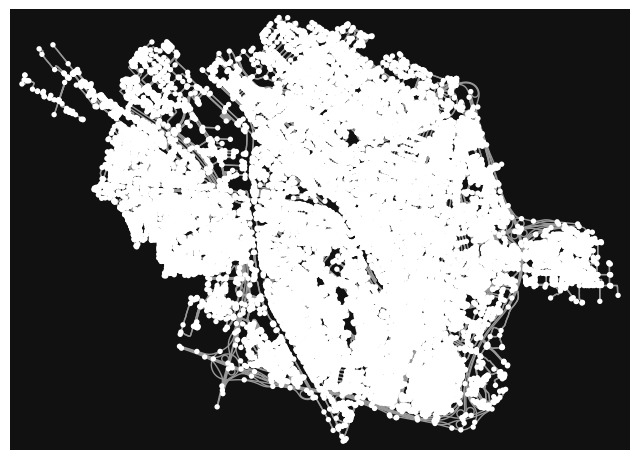

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
osmnx.plot_graph(g)

<Axes: >

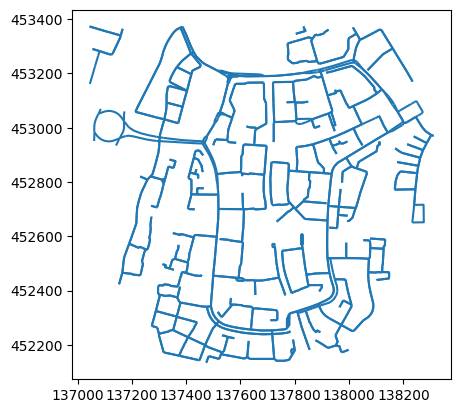

In [ ]:
road_gdf = road_gdf.to_crs(gdf.crs)
road_dba_gdf = gdf.sjoin_nearest(road_gdf, max_distance=10)

<Axes: >

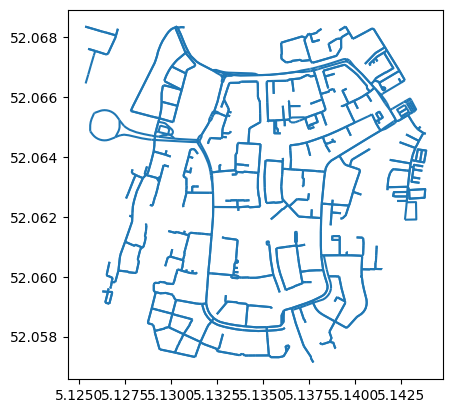

In [ ]:
edge_gdf[edge_gdf['highway'].isin(car_road_types)].plot()

<Axes: >

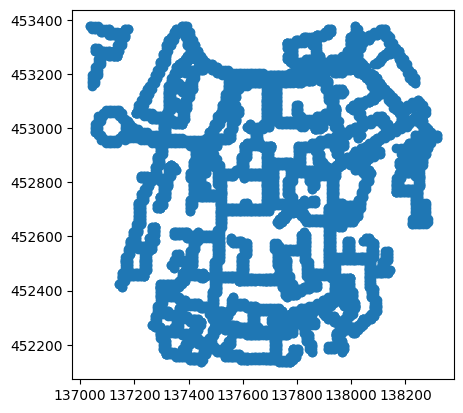

In [ ]:
road_dba_gdf[road_dba_gdf['highway'].isin(car_road_types)].plot()

In [ ]:
road_dba_gdf[road_dba_gdf['maxspeed'].notna()]['highway'].value_counts()

highway
residential      3264
living_street    1809
tertiary          879
footway           374
service           266
cycleway          149
pedestrian        115
path               96
busway             65
secondary          63
unclassified       54
primary_link       24
Name: count, dtype: int64

In [ ]:
road_dba_gdf[road_dba_gdf['highway'] == 'primary_link']

,y,x,dBA_rivm,median_speed,median_dBA_raw,median_dBA_reg_adj,geometry,index_right0,index_right1,index_right2,osmid,highway,width,oneway,reversed,length,name,maxspeed,est_width,bridge,lanes,service,tunnel,access,junction
1114694,453075.0,137085.0,71,NaN,NaN,NaN,POINT (137085.000 453075.000),370654824,10760114233,0,393601995,primary_link,NaN,True,False,19.311,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1116002,453065.0,137075.0,71,NaN,NaN,NaN,POINT (137075.000 453065.000),370654824,10760114233,0,393601995,primary_link,NaN,True,False,19.311,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1116003,453065.0,137085.0,72,20.592447,82.213588,71.291929,POINT (137085.000 453065.000),370654824,10760114233,0,393601995,primary_link,NaN,True,False,19.311,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1116011,453065.0,137165.0,70,NaN,NaN,NaN,POINT (137165.000 453065.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1116012,453065.0,137175.0,72,34.968595,92.241797,73.695430,POINT (137175.000 453065.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1117311,453055.0,137075.0,73,NaN,NaN,NaN,POINT (137075.000 453055.000),370654824,10760114233,0,393601995,primary_link,NaN,True,False,19.311,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1117320,453055.0,137165.0,71,NaN,NaN,NaN,POINT (137165.000 453055.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1117321,453055.0,137175.0,72,NaN,NaN,NaN,POINT (137175.000 453055.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1118629,453045.0,137165.0,72,NaN,NaN,NaN,POINT (137165.000 453045.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN
1118630,453045.0,137175.0,72,31.592349,88.999096,72.243396,POINT (137175.000 453045.000),10760114226,370654821,0,142607073,primary_link,NaN,True,False,34.588,Waterlinieweg,50,NaN,NaN,2,NaN,NaN,NaN,NaN


In [80]:
osmnx.settings.useful_tags_way += ["railway"]
bbox_ut = (52.053757,52.135595,5.070534,5.191383)
t = osmnx.features_from_bbox(bbox=bbox_sp, tags={'shop': True, 'amenity':True})
# n, e = osmnx.graph_to_gdfs(t)
# e


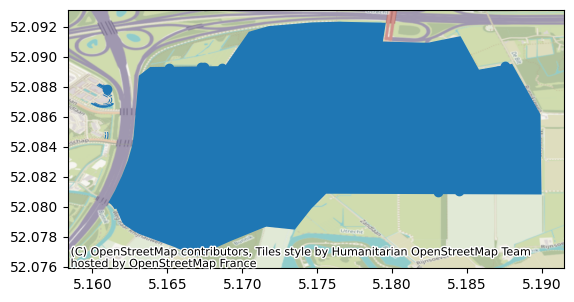

In [81]:
ax = t.plot()
cx.add_basemap(ax, crs=t.crs)

In [82]:
t

geometry  \
element_type osmid                                                           
node         583510005                            POINT (5.17485 52.09115)   
             764621390                            POINT (5.17554 52.08140)   
             764621398                            POINT (5.17321 52.08259)   
             764621410                            POINT (5.17437 52.08179)   
             764621420                            POINT (5.17216 52.08683)   
...                                                                    ...   
way          1254655215  POLYGON ((5.17576 52.08583, 5.17569 52.08583, ...   
             1254655216  POLYGON ((5.17577 52.08593, 5.17569 52.08593, ...   
             1254655217  POLYGON ((5.17557 52.08583, 5.17557 52.08576, ...   
relation     5918380     POLYGON ((5.18345 52.08952, 5.18331 52.08981, ...   
             6308563     POLYGON ((5.17813 52.09142, 5.17804 52.09141, ...   

                          amenity                            name backrest  \
element_type osmid                                                           
node         583510005        pub               Sportcafé Olympos      NaN   
             764621390      bench                             NaN      yes   
             764621398      bench                             NaN      yes   
             764621410      bench                             NaN      yes   
             764621420      bench                             NaN       no   
...                           ...                             ...      ...   
way          1254655215   parking                             NaN      NaN   
             1254655216   parking                             NaN      NaN   
             1254655217   parking                             NaN      NaN   
relation     5918380     hospital  Prinses Máxima Centrum Utrecht      NaN   
             6308563      parking                P+R Science Park      NaN   

                                mapillary       source:position survey:date  \
element_type osmid                                                            
node         583510005                NaN                   NaN         NaN   
             764621390    501333337663638  Mapillary 2019-06-09  2018-06-28   
             764621398   3904542882993441                   NaN  2018-06-28   
             764621410    727057717963192                   NaN  2018-06-28   
             764621420    502681667535620                   NaN  2018-02-17   
...                                   ...                   ...         ...   
way          1254655215               NaN                   NaN         NaN   
             1254655216               NaN                   NaN         NaN   
             1254655217               NaN                   NaN         NaN   
relation     5918380                  NaN                   NaN         NaN   
             6308563                  NaN                   NaN         NaN   

                        bicycle_parking capacity covered  ... building:levels  \
element_type osmid                                        ...                   
node         583510005              NaN      NaN     NaN  ...             NaN   
             764621390              NaN      NaN     NaN  ...             NaN   
             764621398              NaN      NaN     NaN  ...             NaN   
             764621410              NaN      NaN     NaN  ...             NaN   
             764621420              NaN      NaN     NaN  ...             NaN   
...                                 ...      ...     ...  ...             ...   
way          1254655215             NaN      NaN     NaN  ...             NaN   
             1254655216             NaN      NaN     NaN  ...             NaN   
             1254655217             NaN      NaN     NaN  ...             NaN   
relation     5918380                NaN      NaN     NaN  ...             NaN   
             6308563                

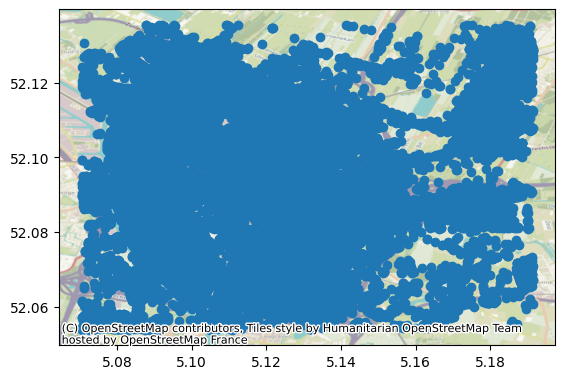

In [73]:
ax = n.plot()
import contextily as cx
cx.add_basemap(ax, crs=n.crs)

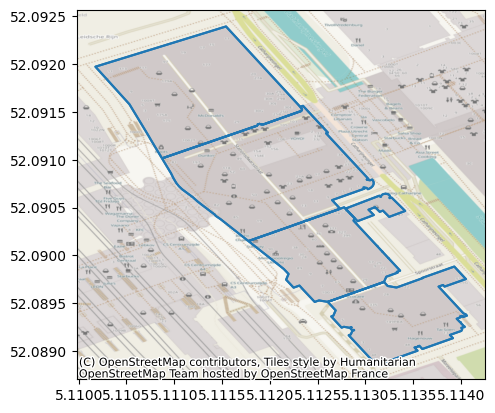

In [56]:
ax = e.plot()
import contextily as cx
cx.add_basemap(ax, crs=e.crs)

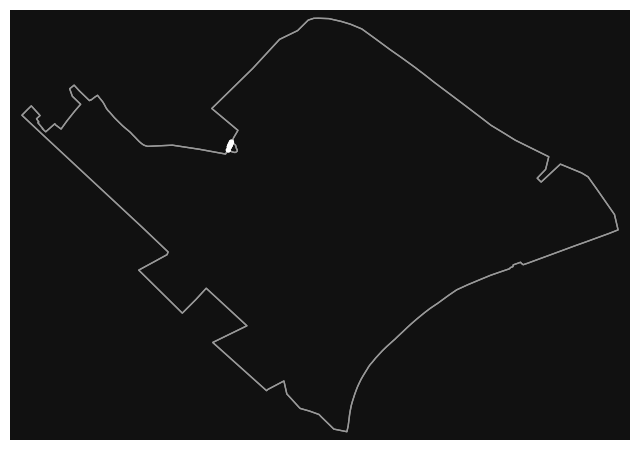

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [53]:
osmnx.plot.plot_graph(t)

## Adding distance to train track

## Adding urban height parameter